using the data of hazardous asteroids real domain 1(haz_real_domain1) , non hazardous real domain 1(nohaz_real_domain1) & non uniform data of both asteroids
data was in.p ,so importing pickle to read and write

In [7]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from copy import copy, deepcopy
from sklearn import neighbors,svm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Loading the data

In [4]:
#loading the real asteroid data
haz_real_dom1=pickle.load(open("haz_real_domain1.p","rb"))
nonhaz_real_dom1=pickle.load(open("nohaz_real_domain1.p","rb"))

#virtually generated non uniform distributed data
haz_virt_dom1=pickle.load(open("haz_nonuniform_domain1.p","rb"))
nonhaz_virt_dom1=pickle.load(open("nohaz_nonuniform_domain1.p","rb"))

In [5]:
haz_real_dom1=haz_real_dom1[haz_real_dom1["q"]<1.066]
nonhaz_virt_dom1=nonhaz_virt_dom1[nonhaz_virt_dom1["q"]<1.066]
haz_virt_dom1=haz_virt_dom1[haz_virt_dom1["q"]<1.066]
nonhaz_real_dom1=nonhaz_real_dom1[nonhaz_real_dom1["q"]<1.066]
print("No of real asteroids:",len(haz_real_dom1)+len(nonhaz_real_dom1))
print("No of virtual asteroids:",len(haz_virt_dom1)+len(nonhaz_virt_dom1))

No of real asteroids: 5177
No of virtual asteroids: 5177


In [6]:
haz_real_dom1.head()

,neo,pha,H,e,a,q,i,om,w,moid
1,Y,Y,15.60,0.335440,1.245302,0.827578,13.337348,337.195397,276.915042,0.029829
5,Y,Y,16.00,0.299182,1.290100,0.904126,64.006898,94.362447,61.539398,0.043465
9,Y,Y,14.00,0.423060,1.768890,1.020543,22.142394,336.080444,27.841220,0.044198
13,Y,Y,16.40,0.541544,2.198616,1.007970,13.534389,82.087387,204.252092,0.020620
15,Y,Y,15.99,0.630864,2.626611,0.969577,2.798293,266.818673,95.388212,0.043087


In [7]:
nonhaz_virt_dom1.head()

,neo,pha,H,e,a,q,i,om,w,moid
2,Y,N,15.54,0.606568,2.258733,0.888658,18.400110,346.443886,268.061952,0.182839
5,Y,N,12.40,0.538064,1.893972,0.874894,41.201391,63.495063,293.059895,0.104496
6,Y,N,13.90,0.505604,2.148813,1.062364,23.962109,188.311231,194.530130,0.071629
7,Y,N,15.75,0.256001,1.430457,1.064259,8.706410,246.330842,338.392148,0.062212
8,Y,N,16.40,0.535483,2.264866,1.052068,3.798260,207.391002,157.034345,0.056043


Now we want to separate the domain 1 into groups of atiras and atens

**For Atiras**

In [8]:
#in research paper , for atiras a<1 AU and Q<0.983AU , Q is aphelion distance i.e 2a-q not the q(perihilion distance)
def get_atiras(data):
    # df=data[data.a>=0]
    df=data[data["a"]<=1]
    Q=df["a"]*2-df["q"]
    Q_fit = Q[Q <= 0.983]
    df2 = df.loc[Q_fit.index]
    return df2

**For Atens**

In [9]:
def get_atens(data):
    # df=data[data.a>=0]
    df= data[data["a"]<= 1]
    Q = df["a"]* 2 - df["q"]
    Q_fit = Q[Q >= 0.983]
    df2 = df.loc[Q_fit.index]
    return df2

In [10]:
#we got atiras and atens data for both real and virtual datasets in hazardous and nonhazardous asteroid datasets,
#For atiras , hazardous and non hazardous virtual and real atiras
haz_real_atiras=get_atiras(haz_real_dom1)
nonhaz_real_atiras=get_atiras(nonhaz_real_dom1)

haz_virt_atiras=get_atiras(haz_virt_dom1)
nonhaz_virt_atiras=get_atiras(nonhaz_virt_dom1)

In [11]:
haz_real_atiras.head()

,neo,pha,H,e,a,q,i,om,w,moid


In [12]:
print(len(nonhaz_virt_atiras))
print(len(haz_virt_atiras))
print(len(nonhaz_real_atiras))
print(len(haz_real_atiras))

2
0
2
0


In [13]:
#For atens , hazardous and non hazardous virtual and real atens
haz_real_atens=get_atens(haz_real_dom1)
nonhaz_real_atens=get_atens(nonhaz_real_dom1)

haz_virt_atens=get_atens(haz_virt_dom1)
nonhaz_virt_atens=get_atens(nonhaz_virt_dom1)

In [14]:
print(len(haz_virt_atens))
print(len(nonhaz_virt_atens))
print(len(haz_real_atens))
print(len(nonhaz_real_atens))

38
2
38
2


In [15]:
nonhaz_virt_atens.head()

,neo,pha,H,e,a,q,i,om,w,moid
3227,Y,N,19.1,0.12743,0.931427,0.812736,46.695846,344.895682,277.767270,0.058277
3671,Y,N,22.7,0.15146,0.913784,0.775383,5.860471,177.851136,90.637177,0.053124


we've got the atiras and atens data for both virtual and real asteroids
concatenating both atiras and atens data as they both constitutes similar properties , and can apply linear kernel on them

In [16]:
haz_real_atiras_atens=pd.concat([haz_real_atiras,haz_real_atens])
nonhaz_real_atiras_atens=pd.concat([nonhaz_real_atiras,nonhaz_real_atens])

haz_virt_atiras_atens=pd.concat([haz_virt_atiras,haz_virt_atens])
nonhaz_virt_atiras_atens=pd.concat([nonhaz_virt_atiras,nonhaz_virt_atens])


In [17]:
haz_real_atiras_atens.head()

,neo,pha,H,e,a,q,i,om,w,moid
912,Y,N,24.7,0.066934,0.977461,0.912036,0.112126,191.960116,275.302777,0.000811
947,Y,N,24.5,0.057271,0.989193,0.932541,11.631879,357.782627,306.644342,0.024475
950,Y,N,24.8,0.027952,0.982900,0.955426,5.245202,183.048928,233.629202,0.002036
1040,Y,N,24.1,0.013006,0.992540,0.979631,10.748083,106.365948,101.897029,0.012036
1145,Y,N,24.3,0.201235,0.983981,0.785969,2.341767,216.421587,78.738627,0.001860


In [18]:
nonhaz_virt_atiras_atens.head()

,neo,pha,H,e,a,q,i,om,w,moid
5539,NaN,NaN,NaN,1.000647,-1401.370962,0.906702,74.880730,355.856479,271.861490,0.493683
5547,NaN,NaN,NaN,1.000016,-63413.805719,1.044176,6.351289,235.257768,68.316272,0.102922
3227,Y,N,19.1,0.127430,0.931427,0.812736,46.695846,344.895682,277.767270,0.058277
3671,Y,N,22.7,0.151460,0.913784,0.775383,5.860471,177.851136,90.637177,0.053124


In [19]:
print("NO of virtual PHA in group:",len(haz_virt_atiras_atens))
print("NO of virtual NHA in group:",len(nonhaz_virt_atiras_atens))
print("NO of real NHA in group:",len(haz_real_atiras_atens))
print("NO of real PHA in gorup:",len(nonhaz_real_atiras_atens))

NO of virtual PHA in group: 38
NO of virtual NHA in group: 4
NO of real NHA in group: 38
NO of real PHA in gorup: 4


As said in the research paper The Atiras & Atens in the 1st domain can be easily separated by the SVM with a linear kernel in the (a, i) plane.


In [20]:
def visualise_data(parameters,haz,nonhaz,figsize=(20,20),s=2):
    haz_cut = haz[parameters].to_numpy()
    nonhaz_cut = nonhaz[parameters].to_numpy()

    fig,(plot1,plot2)=plt.subplots(1,2,figsize=figsize)

    plot1.scatter(nonhaz_cut[:, 0], nonhaz_cut[:, 1], color='blue', label='Non-PHAs',s=2)
    plot2.scatter(haz_cut[:, 0], haz_cut[:, 1], color='red', label='PHAs',s=2)

    plot1.legend()
    plot2.legend()

    plt.show()

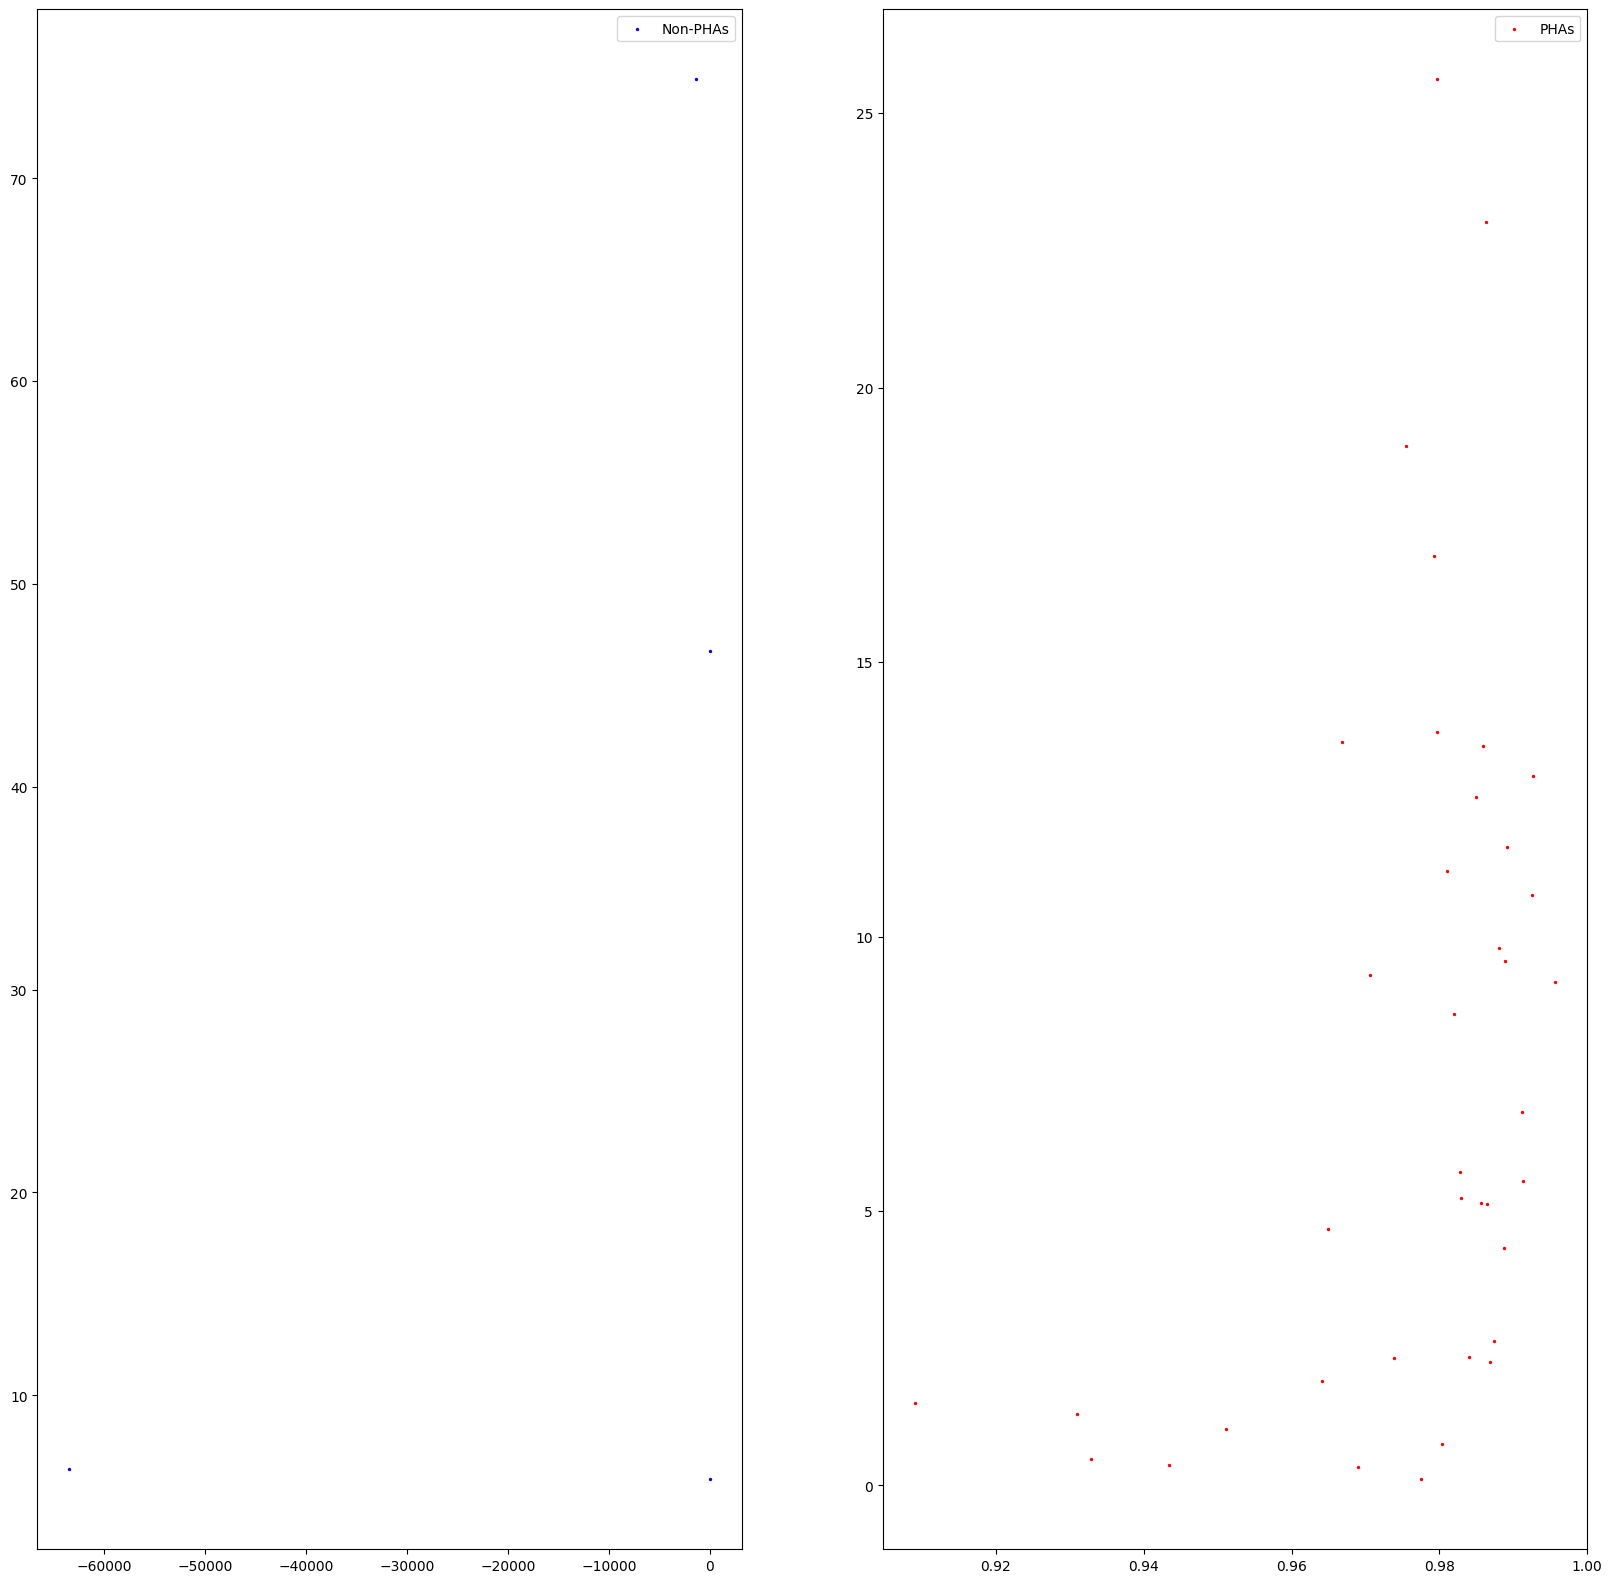

In [21]:
parameters=["a","i"]
visualise_data(parameters,haz_virt_atiras_atens,nonhaz_virt_atiras_atens)

In [22]:
def cut_normalize(parameters, haz, nonhaz):
    haz_cut = haz[parameters].to_numpy()
    nonhaz_cut = nonhaz[parameters].to_numpy()

    # Normalising datasets
    scaler = StandardScaler()
    haz_cut = scaler.fit_transform(haz_cut)
    nonhaz_cut = scaler.transform(nonhaz_cut)

    return haz_cut, nonhaz_cut

In [23]:
haz_real_cut,nonhaz_real_cut=cut_normalize(parameters,haz_real_atiras_atens,nonhaz_real_atiras_atens)
haz_virt_cut,nonhaz_virt_cut=cut_normalize(parameters,haz_virt_atiras_atens,nonhaz_virt_atiras_atens)


In [24]:
def mix_up(hazarr, nohazarr):
    """Generates train data from arrays of PHAs and NHAs"""
    num_haz, num_nohaz = len(hazarr), len(nohazarr)

    phacol = np.concatenate([np.ones(num_haz), np.zeros(num_nohaz)])
    join_train = np.concatenate([hazarr, nohazarr])

    # Split the data into training and testing sets, shuffling the data
    xdata_train, _, ydata_train, _ = train_test_split(join_train, phacol, test_size=0.5, shuffle=True, random_state=42)

    return xdata_train, ydata_train

In [25]:
model=LinearSVC(max_iter=10000)
x_train,y_train=mix_up(haz_virt_cut,nonhaz_virt_cut)

model=model.fit(x_train,y_train)

In [26]:
haz_haz=model.predict(haz_virt_cut)

In [27]:
import matplotlib.pyplot as plt
import numpy as np


def plot_clf2d(clf, haz_cut=None, nohaz_cut=None, scales=None, figsize=(10, 10), cmap='winter_r', s=2, alpha=1):

    if scales is None:
        scales = [(0, 1), (0, 1)]

    fig, ax = plt.subplots(figsize=figsize)

    xmin, xmax = scales[0]
    ymin, ymax = scales[1]
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)


    if nohaz_cut is not None:
        ax.scatter(nohaz_cut[:, 0], nohaz_cut[:, 1], color='darkblue', s=s, alpha=alpha, label='Non-Hazardous')

    if haz_cut is not None:
        ax.scatter(haz_cut[:, 0], haz_cut[:, 1], color='yellow', s=s, alpha=alpha, label='Hazardous')


    cmap_background = ListedColormap(['#98eff9', '#ffffb3'])
    ax.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3, levels=[-1, 0, 1], extend='both')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    plt.show()



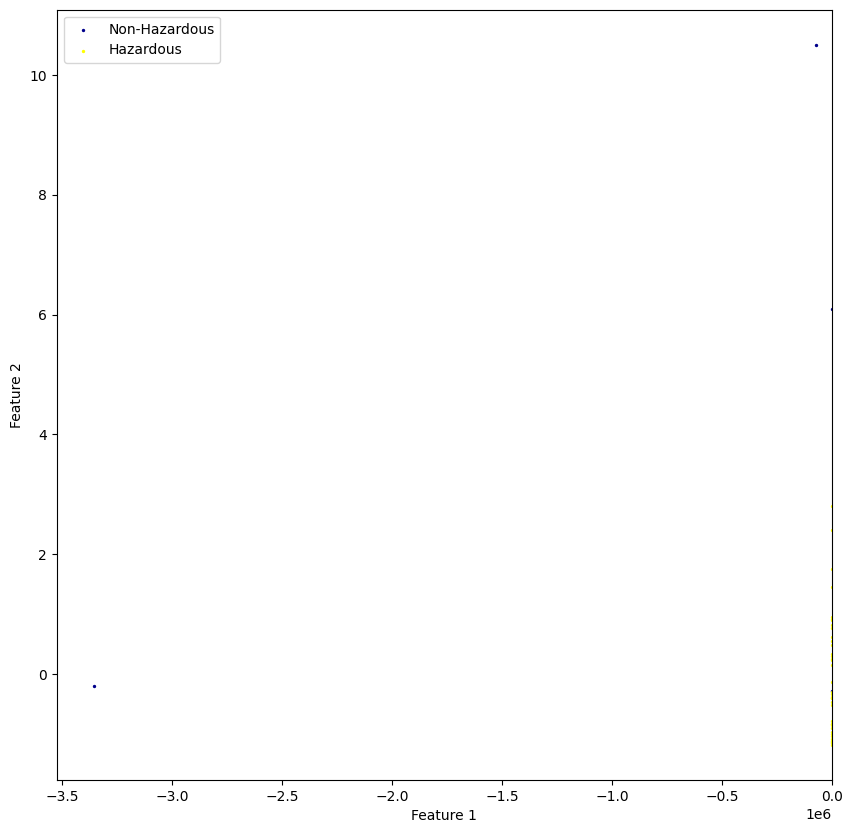

1.0


In [28]:
plot_clf2d(model,haz_cut=haz_virt_cut,nohaz_cut=nonhaz_virt_cut)
train_predictions = model.predict(x_train)
print(accuracy_score(y_train,train_predictions))


In [29]:
x_test,y_test=mix_up(haz_real_cut,nonhaz_real_cut)
model.fit(x_test,y_test)
y_pred=model.predict(x_test)
print(accuracy_score(y_test,y_pred))

1.0


** For Apollos**

In [3]:
def func1(cols_list,haz_df,nonhaz_df):
    list1=[]
    for i  in [haz_df,nonhaz_df]:
        data= i[cols_list]
        arr=np.array(data)
        list1.append(arr)
    haz1=list1[0]
    nonhaz1=list1[1]
    #d=np.concatenate((haz1,nonhaz1))
    #x_limit=[min(d[:,0]),max(d[:,0])]    # this gives the minimum and maximum values of the first column
    #y_limit=[min(d[:,1]),max(d[:,1])]    # this gives the minimum and maximum values of the second column
       # 0 and 1 show the indexing of the column of the array
    figsize=(20.0,10.0)
    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,2,1)
    ax1.scatter(haz1[:,0],haz1[:,1],color="blue",s=5,alpha=1)
    plt.gca().invert_yaxis()
    ax2=fig.add_subplot(1,2,2)
    ax2.scatter(nonhaz1[:,0],nonhaz1[:,1],color="orange",s=5,alpha=1)
    plt.gca().invert_yaxis()
    plt.show()

In [4]:
def func2(cols_list,haz_df,nonhaz_df):
    list1=[]
    for i  in [haz_df,nonhaz_df]:
        data= i[cols_list]
        arr=np.array(data)
        list1.append(arr)
    haz1=list1[0]
    nonhaz1=list1[1]
    #d=np.concatenate((haz1,nonhaz1))
    figsize=(8.0,8.0)
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    ax.scatter(haz1[:,0],haz1[:,1],color="blue",s=5,alpha=1)
    ax.scatter(nonhaz1[:,0],nonhaz1[:,1],color="orange",s=5,alpha=1)
    plt.gca().invert_yaxis()
    plt.show()

In [5]:
def _adjust_axes(ax, labels=None, xlim=None, ylim=None, invertaxes=[0,0],
                 grid_color=None, gridlines=True, xlines=None, ylines=None):

    if xlines is not None:
        ax.locator_params(axis='x', nbins=xlines)
    if ylines is not None:
        ax.locator_params(axis='y', nbins=ylines)

    if len(xlim) >= 2:
        ax.set_xlim([min(xlim), max(xlim)])
    if len(ylim) >= 2:
        ax.set_ylim([min(ylim), max(ylim)])

    if labels is not None:
        ax.set_ylabel(labels[1])
        ax.set_xlabel(labels[0])

    if invertaxes[0]:
        ax.invert_xaxis()
    if invertaxes[1]:
        ax.invert_yaxis()

    if grid_color is not None:
        xlines = ax.get_xgridlines()
        ylines = ax.get_ygridlines()
        [xl.set_color(grid_color) for xl in xlines]
        [yl.set_color(grid_color) for yl in ylines]
        [xl.set_linewidth(3) for xl in xlines]
        [yl.set_linewidth(3) for yl in ylines]

    ax.grid(gridlines)

def _get_datagrid(x, y, num):
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, num),
                         np.linspace(ymin, ymax, num))
    return xx, yy

def _rescale(data, scales):
    xmin, xmax = scales
    data_sc = data * float(xmax-xmin) + xmin
    return data_sc

_cbar_size = [0.9, 0.05, 0.04, 0.9]
_axsize = [0.09, 0.05, 0.8, 0.9]
colnames = {'a':  "Semi-major axis, AU",
            'q':  "Perihelion distance, AU",
            'i':  "Inclination, deg",
            'e':  "Eccentricity",
            'w':  "Argument of perihelion, deg",
            'om': "Longitude of the ascending node, deg"}

In [8]:
def func3(clf, cutcol, plotbounds=None, num=1e2, haz=None, nohaz=None, labels=True,
                    rescale=True, scales=None, invertaxes=[0, 0], figsize=(10,10),
                    cmap=cm.jet, grid_color=None, mode='2d', clf_masks=None,
                    mask_level='above'):
    """
    Plots desicion surface of the classifier trained for a 3-dimensional input data.
    """

    if labels:
        labels = [colnames[i] for i in cutcol]
        labels_xy = labels[:2]
        cb_title = labels[2]
    else:
        labels_xy = None
        cb_title = None

    fig = plt.figure(figsize=figsize)
    if mode == '3d':
        ax = Axes3D(fig)
        # ax = fig.add_subplot(111, projection='3d')
    elif mode == '2d':
        # ax = fig.add_subplot(111)
        ax = fig.add_axes(_axsize)
        cbax = fig.add_axes(_cbar_size)
    else:
        raise AttributeError("'mode' attribute must be one of '2d' and '3d'.")

    if plotbounds is not None:
        xb, yb, zb = plotbounds
    else:
        xb = yb = zb = [0.0, 1.0]

    xx, yy = _get_datagrid(xb, yb, num)
    x_ = xx.ravel()
    y_ = yy.ravel()

    z0 = np.zeros(len(x_))
    zm = deepcopy(z0)
    zlayers = np.linspace(zb[0], zb[1], num)
    # if scales is not None:
    #     zlayers = _rescale(zlayers, scales[2])
    # zsc = max(zlayers) - min(zlayers)

    # apply mask for the points that belong to the subgroup
    if clf_masks is not None:
        for clfm in clf_masks:
            clf_, v = clfm
            c = clf_.predict(np.c_[x_, y_])
            ccut = np.where(c == v)[0]
            zm[ccut] = -1

        # pni = np.where(z0 < 0)[0]
        ppi = np.where(zm == 0)[0]
        xp_ = x_[ppi]
        yp_ = y_[ppi]
        # zp_ = z0[ppi]
        z0_ = np.zeros(len(xp_))
    else:
        # xp_, yp_, zp = x_, y_, z0
        xp_, yp_ = x_, y_
        z0_ = z0

    # extract clf-outlined surface layer by layer
    for zi in zlayers:
        # print "zi:", zi
        zp_ = np.empty(len(yp_))
        # z_ = np.full((len(y_),), zi)
        zp_.fill(zi)

        c = clf.predict(np.c_[xp_, yp_, zp_])
        c1i = np.where(c == 1)[0]
        c0i = np.where(c == 0)[0]

        zp_[c0i] = zp_[c0i] - 2.0
        zp_ = np.maximum(zp_, z0_)
        z0_ = zp_

    if clf_masks is not None:
        z_ = deepcopy(z0)
        # pni = np.where(z0 < 0)[0]
        z_[ppi] = zp_

    else:
        z_ = zp_

    # rescale datapoints
    if scales is not None:
        xxs, yys = _get_datagrid(scales[0], scales[1], num)
        xs_, ys_, zs_ = [_rescale(ar, scales[i]) for i, ar in enumerate([x_, y_, z_])]
        levels = np.linspace(np.min(zs_), np.max(zs_), 100)
    else:
        xxs, yys = xx, yy
        xs_, ys_, zs_ = x_, y_, z_
        levels = np.linspace(0.0, 1.0, 100)

    # lower points not belonging to the subgroup
    if clf_masks is not None:
        pni = np.where(zm < 0)[0]
        # zs_[pni] = 5
        # below = min(zs_) * 2 - max(zs_)
        # below = max(zs_) + 2

        if mask_level == 'above':
            exclude = max(zs_) + 1
        elif mask_level == 'below':
            exclude = min(zs_) - 1
        else:
            raise AttributeError("mask_level argument must by one of 'above' or 'below'.")

        zs_[pni] = exclude

    zzs = zs_.reshape(xx.shape)
    _adjust_axes(ax, labels=labels_xy, xlim=[xxs.min(), xxs.max()],
                 ylim=[yys.min(), yys.max()], invertaxes=invertaxes,
                 grid_color=grid_color, gridlines=True)

    if mode == '3d':
        # ax.plot_surface(xx, yy, zz)
        ax.plot_trisurf(xs_, ys_, zs_, cmap=cmap, linewidth=0)
    else:
        # levels = np.linspace(np.min(zzs), np.max(zzs), 100)
        # levels = np.linspace(0, np.max(zzs), 100)
        print(xxs,yys,zzs)  # added a line
        mpp = ax.contourf(xxs, yys, zzs, cmap=cmap, levels=levels) # cm.jet levels=levels
        # mpp = ax.pcolor(xxs, yys, zzs, cmap=cmap)
        # _add_colorbar(cbax, len(np.unique(z_)), cmap, cb_title)
        # cb = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, orientation='vertical', label=cb_title)
        # cb = ax.add_cbar()
        plt.colorbar(mappable=mpp, cax=cbax, ax=ax, label=cb_title)

    plt.show()

In [9]:
with open('haz_nonuniform_domain1.p', 'rb') as f1:
    # Load the object from the pickle file
    df1 = pickle.load(f1)

with open('nohaz_nonuniform_domain1.p', 'rb') as f2:
    # Load the object from the pickle file
    df2 = pickle.load(f2)

with open('haz_real_domain1.p', 'rb') as f3:
    # Load the object from the pickle file
    df3 = pickle.load(f3)

with open('nohaz_real_domain1.p', 'rb') as f4:
    # Load the object from the pickle file
    df4 = pickle.load(f4)

 data_1 and data_2 are both "Dataframe"

 we need to combine both these so that we get NEA for Domain 1
 then for these NEA in domain 1 we will use SVM RBF Kernel to make decision boundaries using the orbital parameters so that we can make distinction between PHA and NHA
 We will train this model for the training data we have and we also got the output(whether PHA OR NHA) of each row so we can at the end check the accuracy of our model
 by diving the training data into tain and test data

 Data we will use : Real and Non-Uniform NEA Dataset

 PART 1: Getting the Apollos from the 4 databases df1,df2,df3,df4

In [10]:
list1=[df1,df2,df3,df4]
list2=[]
for df in list1 :
    db1 = df[df.a >= 1.0]
    db2 = db1[db1.q <= 1.017]
    list2.append(db2)

haz_virtual=list2[0]
nonhaz_virtual=list2[1]
haz_real=list2[2]
nonhaz_real=list2[3]

In [11]:
print("number of Hazardous virtual apollos",len(haz_virtual))
print("number of Non Hazardous virtual apollos",len(nonhaz_virtual))
print("total virtual apollos",int(len(haz_virtual))+int(len(nonhaz_virtual)))
print("number of hazardous real apollos",len(haz_real))
print("number of non hazardous real apollos",len(nonhaz_real))
print("total real apollos",int(len(haz_real))+int(len(nonhaz_real)))
print()

number of Hazardous virtual apollos 1995
number of Non Hazardous virtual apollos 1169
total virtual apollos 3164
number of hazardous real apollos 1995
number of non hazardous real apollos 1169
total real apollos 3164



# PART 2 : "w-q-i" SURFACE (Processing of the Data)


In [12]:
def split_by_colval(dataset, colname, value):
    dataset_left = dataset[dataset[colname] <= value]
    dataset_right = dataset[dataset[colname] > value]
    return dataset_left, dataset_right

In [13]:
def add_doublemirror_column(dataset, colname, value):
    left, right = split_by_colval(dataset, colname, value)
    left_mir, right_mir = map(deepcopy, [left, right])
    left_mir[colname] = value - left[colname]
    right_mir[colname] = 3*value - right[colname]
    half_mirror = pd.concat((left_mir, right_mir, dataset))
    dataset_mirror = deepcopy(half_mirror)
    dataset_mirror[colname] = value*2 - dataset_mirror[colname]
    dataset_extended = pd.concat((half_mirror, dataset_mirror))
    return dataset_extended

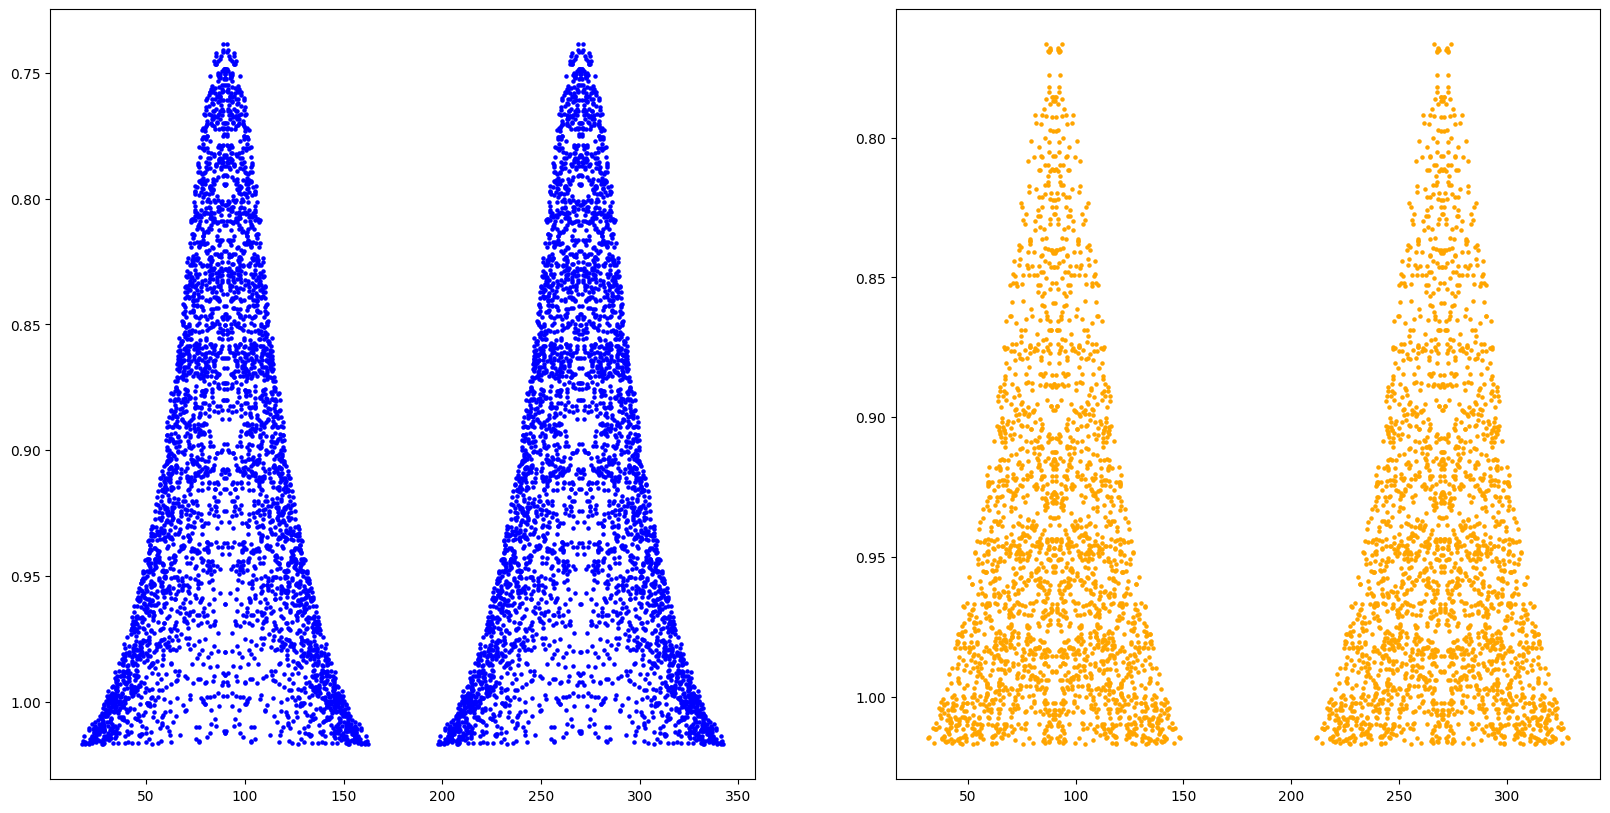

In [14]:
haz_virtual_apollo = add_doublemirror_column(haz_virtual, 'w', 180.0)
nonhaz_virtual_apollo =add_doublemirror_column(nonhaz_virtual, 'w', 180.0)

col=["w","q"]
func1(col,haz_virtual_apollo,nonhaz_virtual_apollo)

haz_gen_apollo_bq = haz_virtual[haz_virtual.q > 0.7]
nohaz_gen_apollo_bq = nonhaz_virtual[nonhaz_virtual.q > 0.7]

haz_gen_apollo_sq = haz_virtual[haz_virtual.q <= 0.7]
nohaz_gen_apollo_sq = nonhaz_virtual[nonhaz_virtual.q <= 0.7]

haz_gen_apollo_se_bq = haz_virtual_apollo[haz_virtual_apollo.q > 0.7]
nohaz_gen_apollo_se_bq = nonhaz_virtual_apollo[nonhaz_virtual_apollo.q > 0.7]


In [15]:
def cut_params(hazdf, nohazdf, cutcol):
    data_arr = []
    for dataframe in [hazdf, nohazdf]:
        if dataframe is not None:
            cutdata = dataframe[cutcol]
            arr = np.array(cutdata)
        else: arr = None
        data_arr.append(arr)
    return data_arr

In [16]:
def normalize_dataset(dataset, bounds=None, copy=True):
    if copy:
        dataset_out = np.zeros_like(dataset)
    else:
        dataset_out = dataset

    if len(dataset.shape) > 1:
        scales = []
        ncol = dataset.shape[1]
        for col in range(ncol):
            if bounds is None:
                col_min, col_max = np.min(dataset[:, col]), np.max(dataset[:, col])
            else:
                col_min, col_max = bounds[0][col], bounds[1][col]

            scales.append((col_min, col_max))
            scale = col_max - col_min
            dataset_out[:, col] = (dataset[:, col] - col_min)/scale
    else:
        if bounds is None:
            data_min, data_max = np.min(dataset), np.max(dataset)
        else:
            data_min, data_max = bounds[0][0], bounds[1][0]

        scale = data_max - data_min
        scales = [data_min, data_max]
        dataset_out = (dataset - data_min)/scale

    return dataset_out, scales

In [17]:
def common_scales(scale_sets):
    scales = np.concatenate(scale_sets, axis=1)
    scales_ = []
    for col_minmax in scales:
        min_val = min(col_minmax)
        max_val = max(col_minmax)
        scales_.append((min_val, max_val))
    return scales_

In [18]:
def common_bounds(datasets):
    ncols = [dataset.shape[1] for dataset in datasets]
    if len(np.unique(ncols)) > 1:
        raise ValueError("number of columns in datasets does not match")
    ncol = ncols[0]
    min_vals = [None]*ncol
    max_vals = [None]*ncol
    for dataset in datasets:
        for col in range(ncol):
            col_min, col_max = np.min(dataset[:, col]), np.max(dataset[:, col])
            comp_min = (col_min, min_vals[col])
            min_vals[col] = min(comp_min) if None not in comp_min else col_min
            max_vals[col] = max(col_max, 0 if max_vals[col]==None else max_vals[col])   # minute changes
    return (min_vals, max_vals)

In [19]:
def cut_normalize(cutcol, haz_nohaz_pairs):
    pair_cuts = []
    for pair in haz_nohaz_pairs:
        haz_cut, nohaz_cut = cut_params(pair[0], pair[1], cutcol)
        pair_cuts.append([haz_cut, nohaz_cut])

    all_cuts = [cut for pair in pair_cuts for cut in pair]
    bounds = common_bounds(all_cuts)

    cut_scales = []
    for cut in all_cuts:
        cut_norm, sc = normalize_dataset(cut, bounds, copy=False)
        cut_scales.append(sc)

    scales = common_scales(cut_scales)

    return pair_cuts, scales

In [20]:
ColList = ['w', 'q', 'i']
pairs, apollo_wqi_sc = cut_normalize(ColList,[[haz_virtual, nonhaz_virtual],[haz_real, nonhaz_real],[haz_gen_apollo_se_bq, nohaz_gen_apollo_se_bq]])

haz_virtual_cut, nonhaz_virtual_cut = pairs[0]     # 2d array with columns w,q,i in it.
haz_real_cut, nonhaz_real_cut = pairs[1]
haz_virtual_apollo_cut, nonhaz_virtual_apollo_cut = pairs[2]

# PART 2 : "w-q-i" SURFACE (Applying SVM RBF Kernel)

In [21]:
clf_apollo_wqi = svm.SVC(gamma=40.0, C=0.05, class_weight={0: 1.2})

In [22]:
def mix_up(hazarr, nohazarr):
    def append_phacol(arr, label):
        num_samples = len(arr)
        phacol = np.full((num_samples, 1), label)
        return np.concatenate((arr, phacol), axis=1)

    hazarr_ = append_phacol(hazarr, 1)
    nohazarr_ = append_phacol(nohazarr, 0)

    join_train = np.concatenate((hazarr_, nohazarr_))
    data_train = np.random.permutation(join_train)

    xdata_train, ydata_train = data_train[:, :-1], data_train[:, -1]
    return xdata_train, ydata_train

In [23]:
xtrain, ytrain = mix_up(haz_virtual_apollo_cut, nonhaz_virtual_apollo_cut)
clf_apollo_wqi = clf_apollo_wqi.fit(xtrain, ytrain)


In [24]:
def clf_split_quality(clf, haz_cut, nohaz_cut):
    haz_clf = clf.predict(haz_cut)
    nohaz_clf = clf.predict(nohaz_cut)
    # 1 : hazardous and 0 : non hazardous
    haz_1 = np.where(haz_clf == 1)[0]
    nohaz_1 = np.where(nohaz_clf == 1)[0]
    haz_0 = np.where(haz_clf == 0)[0]
    nohaz_0 = np.where(nohaz_clf == 0)[0]

    haz_1num, nohaz_1num = map(len, [haz_1, nohaz_1])
    haz_0num, nohaz_0num = map(len, [haz_0, nohaz_0])

    print ("fraction of correctly classified PHAs:", haz_1num/len(haz_cut))
    accuracy=haz_1num/len(haz_cut)
    return haz_1, nohaz_1, haz_0, nohaz_0,accuracy

In [25]:
predicted_virtual = clf_split_quality(clf_apollo_wqi,haz_virtual_cut, nonhaz_virtual_cut)
print("accuracy for PHA:",predicted_virtual[4]*100)
haz_virtual_apollo_wqi = haz_virtual.iloc[predicted_virtual[0]]
nohaz_virtual_apollo_wqi = nonhaz_virtual.iloc[predicted_virtual[1]]


fraction of correctly classified PHAs: 0.8476190476190476
accuracy for PHA: 84.76190476190476


In [26]:
haz_virtual_apollo_wqi__ = haz_virtual.iloc[predicted_virtual[2]]
nohaz_virtual_apollo_wqi__ = nonhaz_virtual.iloc[predicted_virtual[3]]

In [27]:
predicted_real = clf_split_quality(clf_apollo_wqi,haz_real_cut, nonhaz_real_cut)
print("accuracy for PHA:",predicted_real[4]*100)
haz_real_apollo_wqi = haz_real.iloc[predicted_real[0]]
nohaz_real_apollo_wqi = nonhaz_real.iloc[predicted_real[1]]


fraction of correctly classified PHAs: 0.8476190476190476
accuracy for PHA: 84.76190476190476


In [28]:
haz_real_apollo_wqi__ = haz_real.iloc[predicted_real[2]]
nohaz_real_apollo_wqi__ = nonhaz_real.iloc[predicted_real[3]]


# PART 3 : "w-q-a" SURFACE (DATA PROCESSING)

In [29]:
haz_gen_apollo_wqi__se = add_doublemirror_column(haz_virtual_apollo_wqi__, 'w', 180.0)
nohaz_gen_apollo_wqi__se = add_doublemirror_column(nohaz_virtual_apollo_wqi__, 'w', 180.0)


In [30]:
cutcol = ['w','q','a']
pairs, apollo_wqa_sc = cut_normalize(cutcol, [[haz_virtual_apollo_wqi__, nohaz_virtual_apollo_wqi__],[haz_real_apollo_wqi__, nohaz_real_apollo_wqi__],[haz_gen_apollo_wqi__se, nohaz_gen_apollo_wqi__se]])
haz_virtual_cut, nohaz_virtual_cut = pairs[0]
haz_real_cut, nohaz_real_cut = pairs[1]
haz_virtual_se_cut, nohaz_virtual_se_cut = pairs[2]

[[ 17.76725931  19.07033353  20.37340776 ... 339.62659224 340.92966647
  342.23274069]
 [ 17.76725931  19.07033353  20.37340776 ... 339.62659224 340.92966647
  342.23274069]
 [ 17.76725931  19.07033353  20.37340776 ... 339.62659224 340.92966647
  342.23274069]
 ...
 [ 17.76725931  19.07033353  20.37340776 ... 339.62659224 340.92966647
  342.23274069]
 [ 17.76725931  19.07033353  20.37340776 ... 339.62659224 340.92966647
  342.23274069]
 [ 17.76725931  19.07033353  20.37340776 ... 339.62659224 340.92966647
  342.23274069]] [[0.73871457 0.73871457 0.73871457 ... 0.73871457 0.73871457 0.73871457]
 [0.73983215 0.73983215 0.73983215 ... 0.73983215 0.73983215 0.73983215]
 [0.74094973 0.74094973 0.74094973 ... 0.74094973 0.74094973 0.74094973]
 ...
 [1.01475733 1.01475733 1.01475733 ... 1.01475733 1.01475733 1.01475733]
 [1.01587491 1.01587491 1.01587491 ... 1.01587491 1.01587491 1.01587491]
 [1.01699249 1.01699249 1.01699249 ... 1.01699249 1.01699249 1.01699249]] [[72.89751103 72.89751103 72

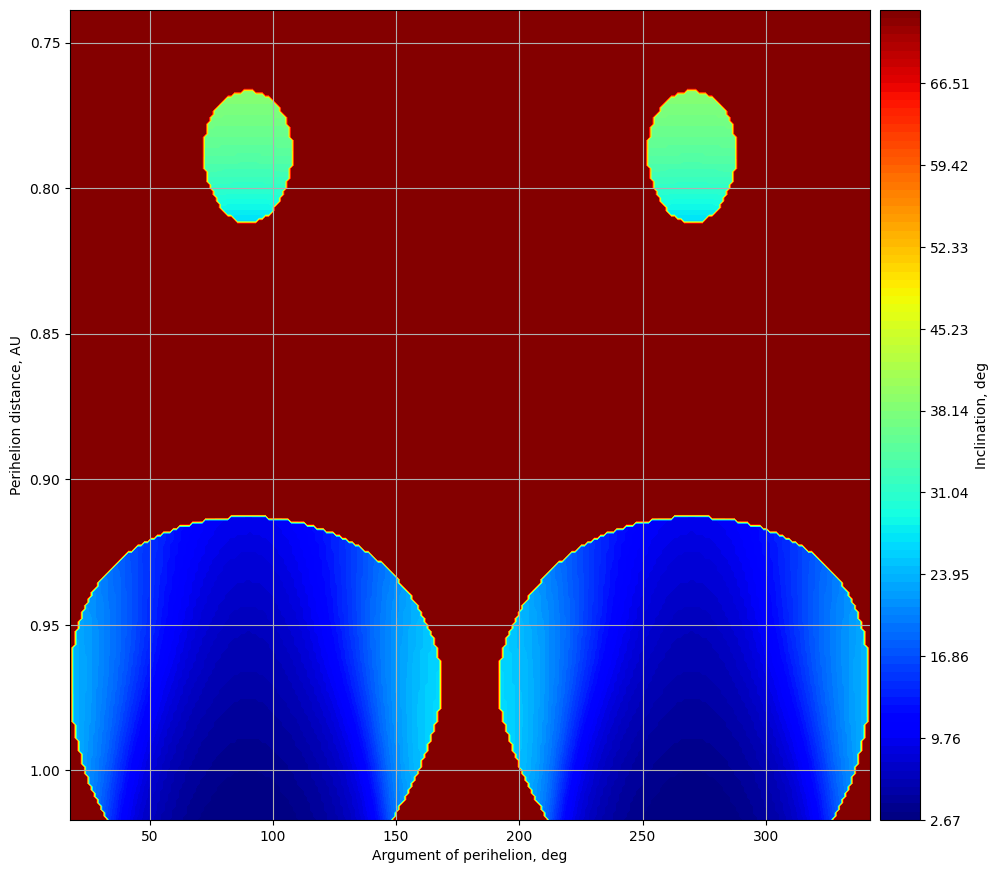

In [56]:
func3(clf_apollo_wqi, ColList, num=250, labels=True, figsize=(10,9), mode='2d',scales=apollo_wqi_sc,clf_masks=None,invertaxes=[0, 1])

# PART 3 : "w-q-a" SURFACE (SVM RBF KERNEL)

In [31]:
clf_apollo_wqa = svm.SVC(gamma=40.0, C=1, class_weight={0: 1})
xtrain, ytrain = mix_up(haz_virtual_se_cut, nohaz_virtual_se_cut)
clf_apollo_wqa = clf_apollo_wqa.fit(xtrain, ytrain)

In [32]:
predicted_virtual =clf_split_quality(clf_apollo_wqa, haz_virtual_cut, nohaz_virtual_cut)

fraction of correctly classified PHAs: 0.9013157894736842


In [33]:
haz_virtual_apollo_wqa = haz_virtual_apollo_wqi__.iloc[predicted_virtual[0]]
nohaz_virtual_apollo_wqa = nohaz_virtual_apollo_wqi__.iloc[predicted_virtual[1]]
haz_virtual_apollo_wqa__ = haz_virtual_apollo_wqi__.iloc[predicted_virtual[2]]
nohaz_virtual_apollo_wqa__ = nohaz_virtual_apollo_wqi__.iloc[predicted_virtual[3]]

In [34]:
predicted_real = clf_split_quality(clf_apollo_wqa, haz_real_cut, nohaz_real_cut)

fraction of correctly classified PHAs: 0.9013157894736842


In [35]:
haz_real_apollo_wqa = haz_real_apollo_wqi__.iloc[predicted_real[0]]
nohaz_real_apollo_wqa = nohaz_real_apollo_wqi__.iloc[predicted_real[1]]
haz_real_apollo_wqa__ = haz_real_apollo_wqi__.iloc[predicted_real[2]]
nohaz_real_apollo_wqa__ = nohaz_real_apollo_wqi__.iloc[predicted_real[3]]

[[ 20.96499662  22.2423862   23.51977579 ... 336.48022421 337.7576138
  339.03500338]
 [ 20.96499662  22.2423862   23.51977579 ... 336.48022421 337.7576138
  339.03500338]
 [ 20.96499662  22.2423862   23.51977579 ... 336.48022421 337.7576138
  339.03500338]
 ...
 [ 20.96499662  22.2423862   23.51977579 ... 336.48022421 337.7576138
  339.03500338]
 [ 20.96499662  22.2423862   23.51977579 ... 336.48022421 337.7576138
  339.03500338]
 [ 20.96499662  22.2423862   23.51977579 ... 336.48022421 337.7576138
  339.03500338]] [[0.76784487 0.76784487 0.76784487 ... 0.76784487 0.76784487 0.76784487]
 [0.76884546 0.76884546 0.76884546 ... 0.76884546 0.76884546 0.76884546]
 [0.76984605 0.76984605 0.76984605 ... 0.76984605 0.76984605 0.76984605]
 ...
 [1.0149913  1.0149913  1.0149913  ... 1.0149913  1.0149913  1.0149913 ]
 [1.0159919  1.0159919  1.0159919  ... 1.0159919  1.0159919  1.0159919 ]
 [1.01699249 1.01699249 1.01699249 ... 1.01699249 1.01699249 1.01699249]] [[1.32561524 1.32561524 1.32561524

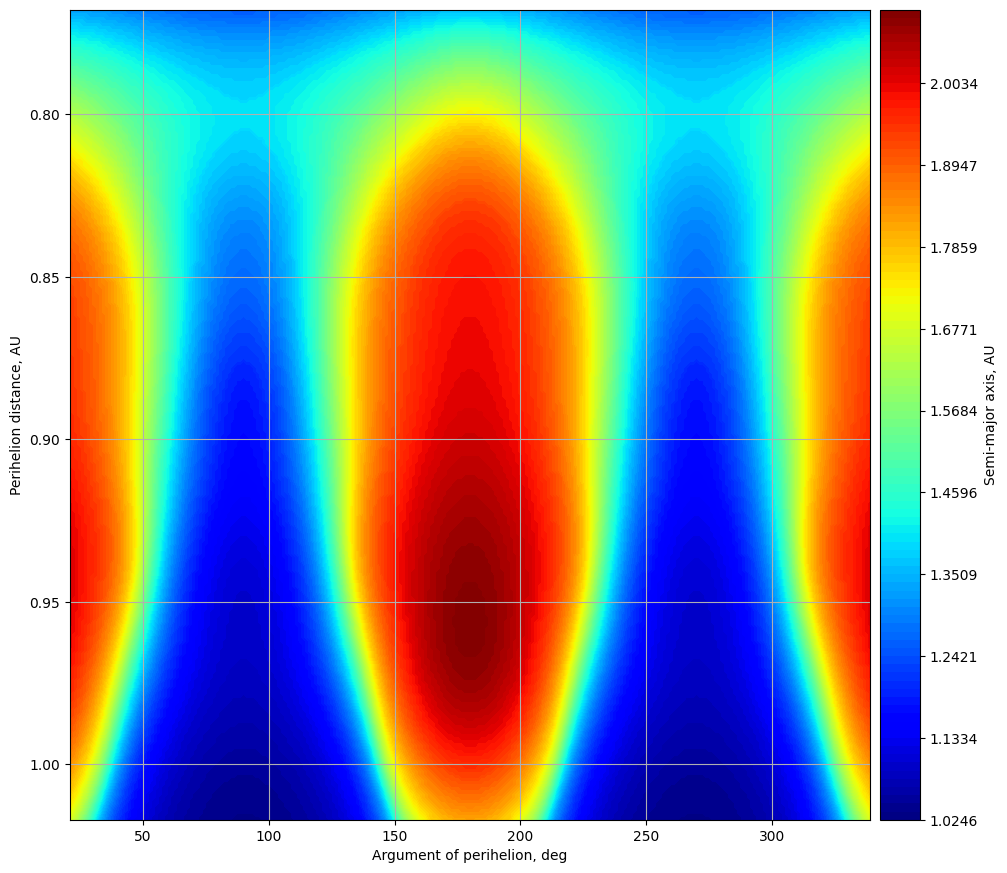

In [36]:
func3(clf_apollo_wqa, cutcol, num=250, labels=True, figsize=(10,9), mode='2d',scales=apollo_wqa_sc, clf_masks= None , invertaxes=[0, 1])

## Amors

In [37]:
col_name = {
    'a':  "Semi-major axis, AU",
    'q':  "Perihelion distance, AU",
    'i':  "Inclination, deg",
    'e':  "Eccentricity",
    'w':  "Argument of perihelion, deg",
    'om': "Longitude of the ascending node, deg"
}

def plot_clf2d(clf, cutcol, haz_cut, nohaz_cut, num=1e2, labels=True,
                scales=None, pointcolors=None, figsize=(10,10), cmap='winter_r', s=5, alpha=1):

    if labels:
        labels = [col_name[i] for i in cutcol]
    else: labels = None

    if scales is None:
        scales = [(0,1), (0,1)]

    xmin, xmax = scales[0]
    ymin, ymax = scales[1]
    fig, ax = plt.subplots(figsize=figsize)
    # plot classifier
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, num),
                         np.linspace(ymin, ymax, num))
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    zz = (z).reshape(xx.shape)

    ax.contourf(xx, yy, zz, cmap=cmap, alpha=0.5)

    # plot scatters
    if pointcolors is None:
        pointcolors = ["yellow", "darkblue"]

    xmin, xmax = scales[0]
    ymin, ymax = scales[1]
    ## Normalizing data
    xdata = nohaz_cut[:, 0]*(xmax - xmin) + xmin
    ydata = nohaz_cut[:, 1]*(ymax - ymin) + ymin
    ax.scatter(xdata, ydata, s=s, c=pointcolors[1], alpha=alpha)

    xdata = haz_cut[:, 0]*(xmax - xmin) + xmin
    ydata = haz_cut[:, 1]*(ymax - ymin) + ymin
    ax.scatter(xdata, ydata, s=s, c=pointcolors[0], alpha=alpha)

    xlim = [xx.min(), xx.max()]
    ylim = [yy.min(), yy.max()]
    ax.set_xlim([min(xlim), max(xlim)])
    ax.set_ylim([min(ylim), max(ylim)])

    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])

    plt.show()


In [38]:
_axsize = [0.09, 0.05, 0.8, 0.9] # [left, bottom, width, height]
_cbar_size = [0.9, 0.05, 0.04, 0.9]

def plot_clf3d(clf, cutcol, num=100, labels=True,
                    scales=None, figsize=(10,12), cmap=plt.cm.jet, mode='2d', gridlines=True):

    if labels:
        labels = [col_name[i] for i in cutcol]
        labels_xy = labels[:2]
        cb_title = labels[2]
    else:
        labels_xy = None
        cb_title = None

    fig = plt.figure(figsize=figsize)
    if mode == '3d':
        ax = Axes3D(fig)
        # ax = fig.add_subplot(111, projection='3d')
    elif mode == '2d':
        ax = fig.add_axes(_axsize)
        cbax = fig.add_axes(_cbar_size)
    else:
        raise AttributeError("'mode' attribute must be one of '2d' and '3d'.")


    xb = yb = zb = [0.0, 1.0]  ## bounds of the axes

    xx, yy = _get_datagrid(xb, yb, num)
    x_ = xx.ravel()     ## 1D array of the grid values
    y_ = yy.ravel()

    z0 = np.zeros(len(x_))
    zm = deepcopy(z0)
    zlayers = np.linspace(zb[0], zb[1], num)

    # apply mask for the points that belong to the subgroup
    xp_, yp_ = x_, y_
    z0_ = z0

    # extract clf-outlined surface layer by layer
    for zi in zlayers:
        zp_ = np.empty(len(yp_))
        zp_.fill(zi)

        c = clf.predict(np.c_[xp_, yp_, zp_])
        c1i = np.where(c == 1)[0]
        c0i = np.where(c == 0)[0]

        zp_[c0i] = zp_[c0i] - 2.0
        zp_ = np.maximum(zp_, z0_)
        z0_ = zp_


    z_ = zp_

    # rescale datapoints
    if scales is not None:
        xxs, yys = _get_datagrid(scales[0], scales[1], num)
        xs_, ys_, zs_ = [_rescale(ar, scales[i]) for i, ar in enumerate([x_, y_, z_])]
        levels = np.linspace(np.min(zs_), np.max(zs_), 100)
    else:
        xxs, yys = xx, yy
        xs_, ys_, zs_ = x_, y_, z_
        levels = np.linspace(0.0, 1.0, 100)

    # lower points not belonging to the subgroup

    zzs = zs_.reshape(xx.shape)

    xlim=[xxs.min(), xxs.max()]
    ylim=[yys.min(), yys.max()]
    ax.set_xlim([min(xlim), max(xlim)])
    ax.set_ylim([min(ylim), max(ylim)])

    ax.set_xlabel(labels_xy[0])
    ax.set_ylabel(labels_xy[1])
    ax.grid(gridlines)

    if mode == '3d':
        ax.plot_trisurf(xs_, ys_, zs_, cmap=cmap, linewidth=0)
    else:
        mpp = ax.contourf(xxs, yys, zzs, cmap=cmap, levels=levels)
        plt.colorbar(mappable=mpp, cax=cbax, ax=ax, label=cb_title)

    plt.show()



def _rescale(data, scales):
    xmin, xmax = scales
    data_sc = data * float(xmax-xmin) + xmin
    return data_sc

def _get_datagrid(x, y, num):
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, num),
                         np.linspace(ymin, ymax, num))
    return xx, yy

In [39]:
# Loading the real asteroids from the .p files.
haz_real = pickle.load(open("haz_real_domain1.p", 'rb'))
nonhaz_real = pickle.load(open("nohaz_real_domain1.p", 'rb'))

# Loading the virtual non-uniform asteroids from the .p files.
haz_vir = pickle.load(open("haz_nonuniform_domain1.p", 'rb'))
nonhaz_vir = pickle.load(open("nohaz_nonuniform_domain1.p", 'rb'))

print("The Number of virtual asteroids in domain1:", len(haz_vir) + len(nonhaz_vir))
print("The Number of real asteroids in domain1:", len(haz_real) + len(nonhaz_real))

vir_dom1_size = len(haz_vir) + len(nonhaz_vir)
real_dom1_size = len(haz_real) + len(nonhaz_real)

The Number of virtual asteroids in domain1: 5636
The Number of real asteroids in domain1: 5636


In [40]:
## NAmes of all the parameters
col_name = {
    'a':  "Semi-major axis, AU",
    'q':  "Perihelion distance, AU",
    'i':  "Inclination, deg",
    'e':  "Eccentricity",
    'w':  "Argument of perihelion, deg",
    'om': "Longitude of the ascending node, deg"
}

def get_amors(data):
    d1 = data[data.a > 1.0]
    d2 = d1[d1.q < 1.3]
    d3 = d2[d2.q > 1.017]
    return d3, len(d3)

## virtual Amors
haz_vir_amors, size_haz_vir_amors = get_amors(haz_vir)
nonhaz_vir_amors, size_nonhaz_vir_amors = get_amors(nonhaz_vir)
size_vir_am = size_haz_vir_amors + size_nonhaz_vir_amors

print ("Number of virtual Amors:", size_vir_am)
print ("Amors group weight:", float(size_vir_am)/vir_dom1_size)


## Real Amors
haz_real_amors, size_haz_real_amors = get_amors(haz_real)
nonhaz_real_amors, size_nonhaz_real_amors = get_amors(nonhaz_real)
size_real_am = size_haz_real_amors + size_nonhaz_real_amors

print ("Number of Real Amors:", size_real_am)
print ("Amors group weight:", float(size_real_am)/real_dom1_size)

# Cut off non-hazardous areas by a w-i surface. Here, w and i are the parameters

def add_doublemirror_column(dataset, colname, value):
    left, right = split_by_colval(dataset, colname, value)
    left_mir, right_mir = map(deepcopy, [left, right])
    left_mir[colname] = value - left[colname]
    right_mir[colname] = 3*value - right[colname]
    half_mirror = pd.concat((left_mir, right_mir, dataset))

    dataset_mirror = deepcopy(half_mirror)
    dataset_mirror[colname] = value*2 - dataset_mirror[colname]
    dataset_extended = pd.concat((half_mirror, dataset_mirror))

    return dataset_extended

def split_by_colval(dataset, colname, value):
    dataset_left = dataset[dataset[colname] <= value]
    dataset_right = dataset[dataset[colname] > value]
    return dataset_left, dataset_right

haz_real_amor_exd = add_doublemirror_column(haz_real_amors, 'w', 180.0)
nohaz_real_amor_exd = add_doublemirror_column(nonhaz_real_amors, 'w', 180.0)

Number of virtual Amors: 2429
Amors group weight: 0.4309794180269695
Number of Real Amors: 2429
Amors group weight: 0.4309794180269695


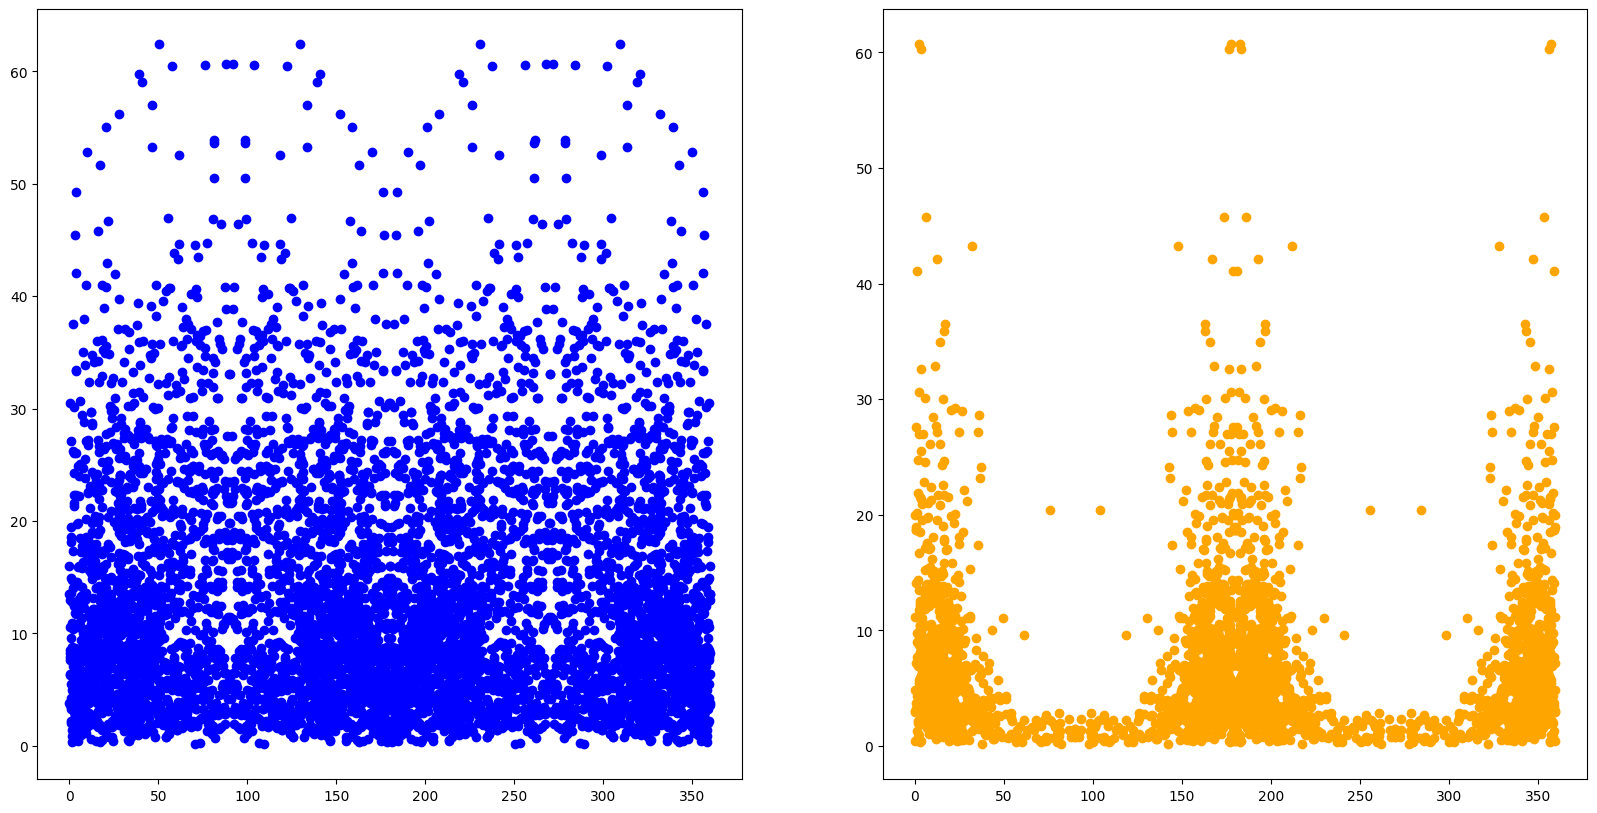

<ipython-input-41-23722cb8e1a6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.iloc[:, col] = (dataset.iloc[:, col] - col_min)/scale
<ipython-input-41-23722cb8e1a6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.iloc[:, col] = (dataset.iloc[:, col] - col_min)/scale
<ipython-input-41-23722cb8e1a6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [41]:
# function to plot NHAs and PHAs separately by two orbital parameters.
def plot_distributions2d(col, haz, nonhaz, labels=True, figsize=(20,10)):
    if labels:
        labels = [col_name[i] for i in col]
    else: labels = None

    haz_cut_x = haz[col[0]]
    haz_cut_y = haz[col[1]]

    nonhaz_cut_x  = nonhaz[col[0]]
    nonhaz_cut_y  = nonhaz[col[1]]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.scatter(nonhaz_cut_x, nonhaz_cut_y, c="blue", label=labels)
    ax2.scatter(haz_cut_x, haz_cut_y, c="orange", label=labels)

    plt.show()


cols = ['w', 'i']
plot_distributions2d(cols, haz_real_amor_exd, nohaz_real_amor_exd)


#  Cut w and i columns and nomalize datasets  #


# Function for cutting & normalizing the dataframes containing NHAs and PHAs
def data_normalize(cols, haz_nohaz_pairs):
    haz_cut = haz_nohaz_pairs[0][cols]
    nohaz_cut = haz_nohaz_pairs[1][cols]

    haz_nohaz_cut = [haz_cut, nohaz_cut]

    scales=[]
    for dataset in haz_nohaz_cut:
        scal = []
        for col in range(len(cols)):
            col_min, col_max = dataset.iloc[:, col].min(), dataset.iloc[:, col].max()

            scal.append((col_min, col_max))
            scale = col_max-col_min
            dataset.iloc[:, col] = (dataset.iloc[:, col] - col_min)/scale
        scales.append(scal)

    ## Common scale
    scales=np.concatenate(scales, axis=1)
    scales1 = []
    for col in range(len(cols)):
        colmin, colmax = np.min(scales[col]), np.max(scales[col])
        scales1.append((colmin, colmax))

    return np.array(haz_cut), np.array(nohaz_cut), scales1


haz_gen_see_cut, nohaz_gen_see_cut, amor_wi_sc1 = data_normalize(cols, [haz_real_amor_exd, nohaz_real_amor_exd])
haz_gen_cut, nohaz_gen_cut, amor_wi_sc2 = data_normalize(cols, [haz_real_amors, nonhaz_real_amors])

In [42]:
# Train - SVM

def mix_up(hazarr, nohazarr):
    num_haz, num_nohaz = len(hazarr), len(nohazarr)

    # Create labels for hazardous and non-hazardous arrays
    labels = np.concatenate([np.ones(num_haz), np.zeros(num_nohaz)])

    # Concatenate hazardous and non-hazardous arrays
    join_train = np.concatenate((hazarr, nohazarr))

    # Split the data into training sets
    xtrain1, xtrain2, ytrain1, ytrain2 = train_test_split(join_train, labels, test_size=0.5, shuffle=True, random_state=42)

    # Concatenate the two halves to get the final training set
    xtrain = np.concatenate([xtrain1, xtrain2])
    ytrain = np.concatenate([ytrain1, ytrain2])

    return xtrain, ytrain

clf_amor_wi = svm.SVC(gamma=30., C=0.1, class_weight={1: 5.5})
xtrain, ytrain = mix_up(haz_gen_see_cut, nohaz_gen_see_cut)
clf_amor_wi = clf_amor_wi.fit(xtrain, ytrain)


def clf_split_quality(clf, haz_cut, nohaz_cut):
    haz_clf = clf.predict(haz_cut)
    nohaz_clf = clf.predict(nohaz_cut)

    haz_1 = np.where(haz_clf == 1)[0]
    nohaz_1 = np.where(nohaz_clf == 1)[0]
    haz_0 = np.where(haz_clf == 0)[0]
    nohaz_0 = np.where(nohaz_clf == 0)[0]

    haz_1num, nohaz_1num = map(len, [haz_1, nohaz_1])
    haz_0num, nohaz_0num = map(len, [haz_0, nohaz_0])

    haz_purity = haz_1num/(haz_1num + nohaz_1num)
    nohaz_purity = nohaz_0num/(haz_0num + nohaz_0num)

    print ("purity of PHA region:", haz_purity)
    print ("number of PHAs in the PHA region:", haz_1num)
    print ("number of NHAs in the PHA region:", nohaz_1num)
    print()
    print ("purity of NHA region:", nohaz_purity)
    print ("number of PHAs in the NHA region:", haz_0num)
    print ("number of NHAs in the NHA region:", nohaz_0num)
    print()
    print ("fraction of correctly classified PHAs:", haz_1num/len(haz_cut))

    return haz_1, nohaz_1, haz_0, nohaz_0

predicted_gen = clf_split_quality(clf_amor_wi, haz_gen_cut, nohaz_gen_cut)   ##contains indexes

## in PHA region
haz_gen_amor_wi = haz_real_amors.iloc[predicted_gen[0]]
nohaz_gen_amor_wi = nonhaz_real_amors.iloc[predicted_gen[1]]
## in NHA region
haz_gen_amor_wi__ = haz_real_amors.iloc[predicted_gen[2]]
nohaz_gen_amor_wi__ = nonhaz_real_amors.iloc[predicted_gen[3]]

purity of PHA region: 0.41881366087477534
number of PHAs in the PHA region: 699
number of NHAs in the PHA region: 970

purity of NHA region: 0.9842105263157894
number of PHAs in the NHA region: 12
number of NHAs in the NHA region: 748

fraction of correctly classified PHAs: 0.9831223628691983


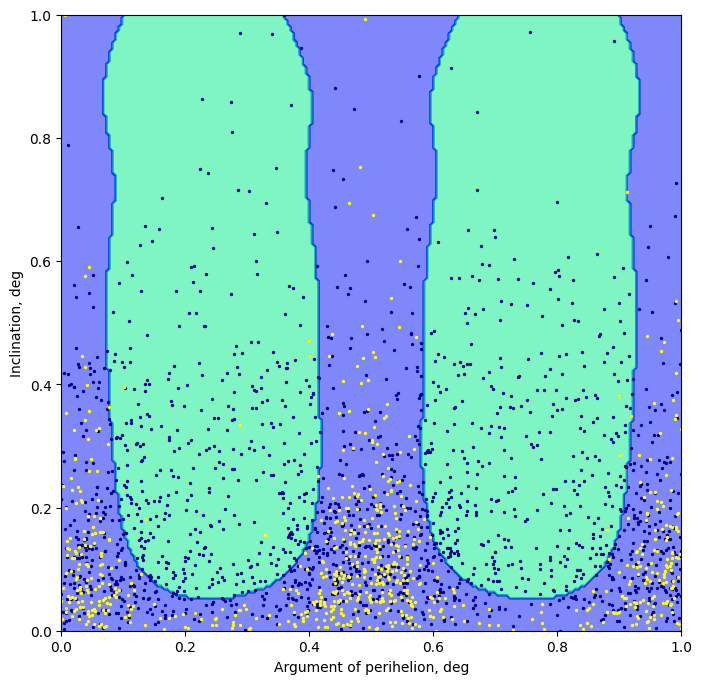

In [43]:
## Decision Surface Plot in 2D

plot_clf2d(clf_amor_wi, cols, haz_gen_cut, nohaz_gen_cut, num=200, s=2,
           figsize=(8,8), labels=True,
           cmap='winter_r')


In [44]:
#  Extract PHA region by a w-om-q surface  #

def add_mirror_column(dataset, colname, value):
    """ Extends dataset by its mirror over the 'value' of the 'colname'. """

    dataset_mirror = deepcopy(dataset)
    dataset_mirror[colname] = value*2 - dataset[colname]
    dataset_extended = pd.concat((dataset, dataset_mirror))

    return dataset_extended


In [45]:
haz_gen_amor_wi_se = add_mirror_column(haz_gen_amor_wi, 'w', 180.0)
nohaz_gen_amor_wi_se = add_mirror_column(nohaz_gen_amor_wi, 'w', 180.0)

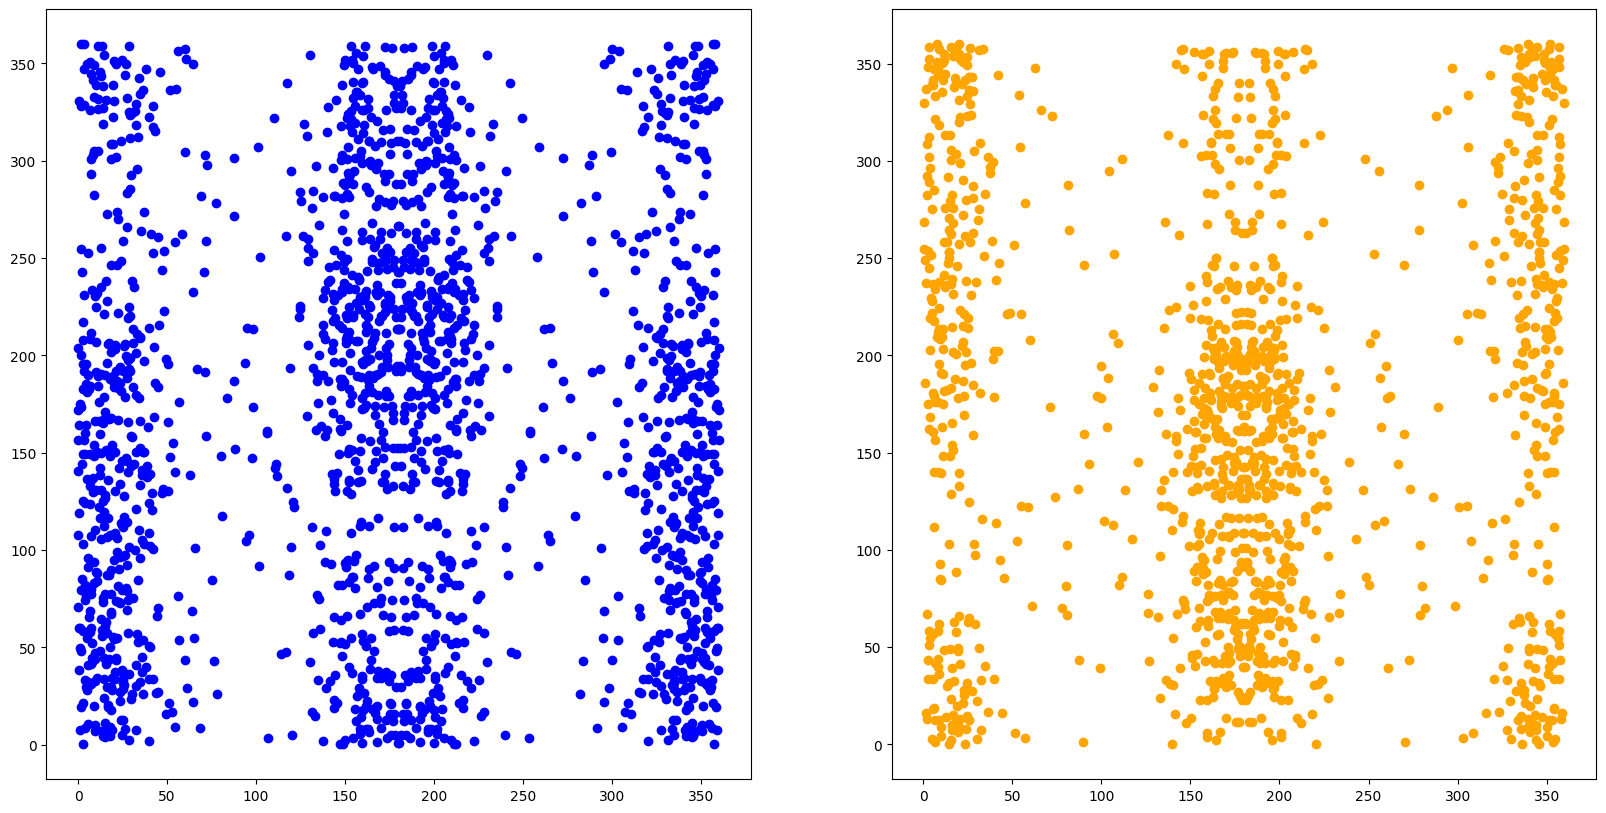

<ipython-input-41-23722cb8e1a6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.iloc[:, col] = (dataset.iloc[:, col] - col_min)/scale
<ipython-input-41-23722cb8e1a6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.iloc[:, col] = (dataset.iloc[:, col] - col_min)/scale
<ipython-input-41-23722cb8e1a6>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

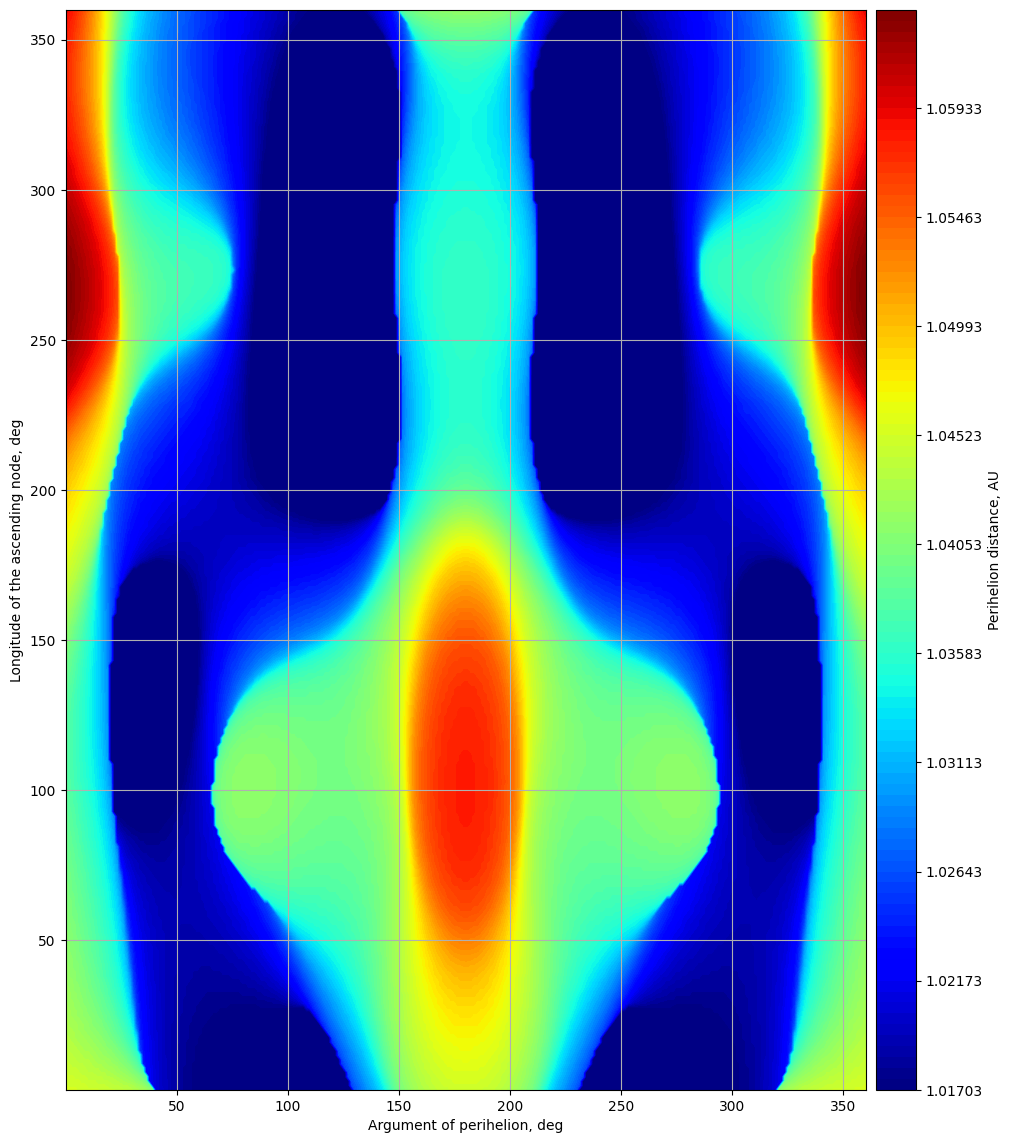

In [46]:
cutcol = ['w', 'om']
plot_distributions2d(cutcol, haz_gen_amor_wi_se, nohaz_gen_amor_wi_se, labels=True)

cutcol = ['w', 'om', 'q']

haz_gen_se_cut, nohaz_gen_se_cut, amor_womq_sc = data_normalize(cutcol, [haz_gen_amor_wi_se, nohaz_gen_amor_wi_se])

## Train_BY_SVM

clf_amor_womq = svm.SVC(gamma=20.0, C=8.0, class_weight={0: 2.4})
xtrain, ytrain = mix_up(haz_gen_se_cut, nohaz_gen_se_cut)
clf_amor_womq = clf_amor_womq.fit(xtrain, ytrain)

## ## Decision Surface Plot in 3D

plot_clf3d(clf_amor_womq, cutcol, num=250, mode='2d', scales=amor_womq_sc)